In [2]:
#imports 

from fastai.vision.all import *

### Pre-processing 

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [5]:
#preview training set
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [6]:
threes  = (path/'train'/'3').ls().sorted()
sevens  = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [7]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [8]:
#Slicing the image after converting to array
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
#Slicing the tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [10]:
#printing the number as an pandas dataframe

im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


### Baseline Model

In [14]:
#Building a baseline model

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<Axes: >

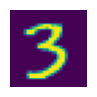

In [15]:
show_image(three_tensors[1])

In [18]:
#Stacking the tensors, converting them to float for certain operations 
#pixel values are expected to be between 0 and 1 (hence division by 255)

stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

stacked_threes.shape

torch.Size([6131, 28, 28])

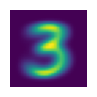

In [20]:
#calculating ideal 3 by taking mean of all images along dimension 0 (this acts as an index)

mean3 = stacked_threes.mean(0)
show_image(mean3);

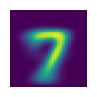

In [21]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

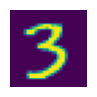

In [23]:
#Calculating the distnace from the ideal and a random sample

a_3 = stacked_threes[1]
show_image(a_3);

In [26]:
#L1 distance or Mean Absolute Difference

dist_3_abs = (a_3 - mean3).abs().mean()
dist_7_abs = (a_3 - mean7).abs().mean()
print('L1 distance of the sample image: \n3 - ',dist_3_abs,'\n7 - ',dist_7_abs)
#L2 distance or Mean Squared Error

dist_3_sqrt = ((a_3 - mean3)**2).mean().sqrt()
dist_7_sqrt = ((a_3 - mean7)**2).mean().sqrt()
print('L2 distance of the sample image: \n3 - ',dist_3_sqrt,'\n7 - ',dist_7_sqrt)

L1 distance of the sample image: 
3 -  tensor(0.1114) 
7 -  tensor(0.1586)
L2 distance of the sample image: 
3 -  tensor(0.2021) 
7 -  tensor(0.3021)


In the both L1 and L2 distances we can see that our sample image is closer to 3 than 7.

In [27]:
#Using PyTorch loss functions 

F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [31]:
#Create a validation set

valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [33]:
#Function which calculates the distance 

def mnist_distance(a,b):
    return (a-b).abs().mean((-1,-2))

In [35]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)

valid_3_dist, valid_3_dist.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

In [36]:
# Check to see if the image is 3

def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [38]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [39]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [41]:
#Calculating the accuracy

accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

### Calculating gradients

In [14]:
#Calculating Gradients

#define function
def f(x): return x**2

#Initialize tensor
xt = tensor(3.).requires_grad_()

```requires_grad_()``` method lets PyTorch know that we want to calculate gradients w.r.t to that variable at that value. 

In [15]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

3x3 is 9

In [16]:
#Backpropagation, basically "calculate_grad"
yt.backward()

#View the gradients
xt.grad

tensor(6.)

the derivate of x<sup>2</sup> is 2x<br>
2 x 3 = 6

In [20]:
#repeating above steps but for a vector argument

xt = tensor([3.,4.,10.]).requires_grad_()
print(xt)

#function
def f(x): return (x**2).sum()

yt = f(xt)
print(yt)

#backprop
yt.backward()
print(xt.grad)

tensor([ 3.,  4., 10.], requires_grad=True)
tensor(125., grad_fn=<SumBackward0>)
tensor([ 6.,  8., 20.])


### Stochastic Gradient Descent example

In [40]:
#End to end SGD example

time = torch.arange(0,20).float();
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

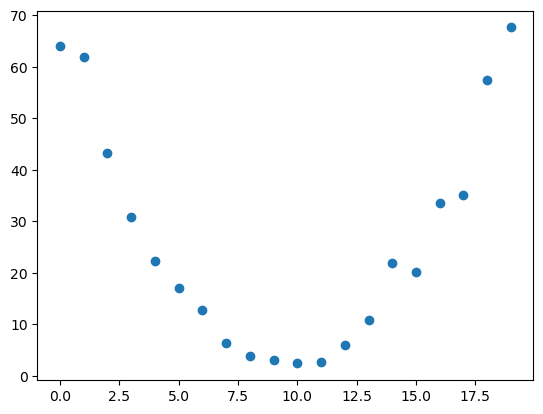

In [41]:
speed = torch.randn(20)*3 + 0.75*(time - 9.5)**2 + 1
plt.scatter(time,speed);

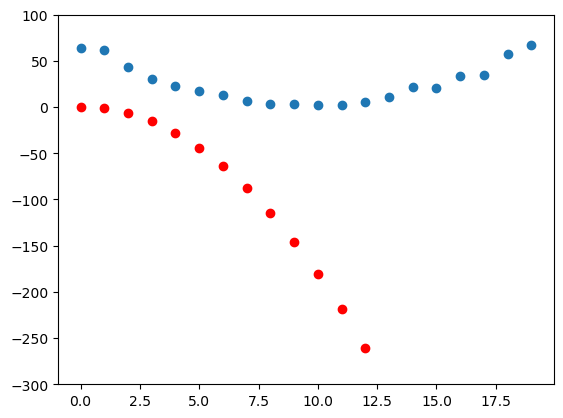

In [42]:
#function assumption 
def f(t, params):
    a,b,c = params
    return a*(t**2) + b*t + c

#loss function
def mse(preds, targets):
    return ((preds - targets)**2).mean()

#STEP 1 - Initialize the parameters
params = torch.randn(3).requires_grad_()

#STEP 2 - Calculate the predictions
preds = f(time, params)

def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

show_preds(preds)

In [43]:
#STEP 3 - Calculate the loss
loss = mse(preds, speed)
loss

tensor(108034.3750, grad_fn=<MeanBackward0>)

In [44]:
#STEP 4 - Calculate the gradients
loss.backward()
print(params.grad)

#Multiply by 1e-5 (learning rate)
params.grad * 1e-5
print(params)



tensor([-109937.1406,   -7050.5098,    -500.3474])
tensor([-1.8379,  0.3049,  0.0476], requires_grad=True)


In [45]:
#STEP 5 - Step the weights
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

tensor(20957.2305, grad_fn=<MeanBackward0>)


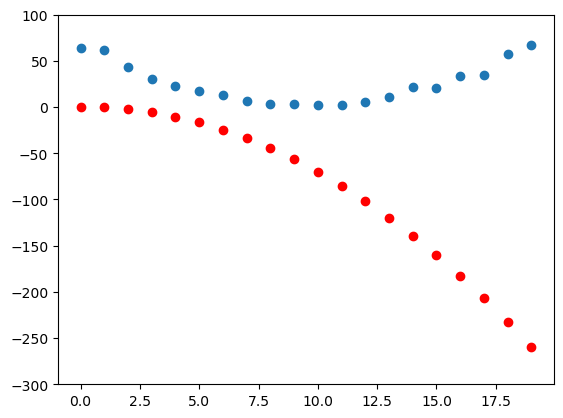

In [49]:
#After 1 step
preds = f(time, params)
print(mse(preds, speed))

show_preds(preds)

In [50]:
#Create a function to apply one step

def apply_step(params, show_loss=True):
    preds = f(time, params)
    loss = mse(speed, preds)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if show_loss: print(loss.item())
    return preds

In [51]:
#STEP 6 - Repeat the process 
for i in range(10): apply_step(params)

20957.23046875
4479.576171875
1361.4986572265625
771.4605712890625
659.8046264648438
638.6734008789062
634.6719970703125
633.9122314453125
633.7658081054688
633.7354736328125


In [ ]:
#STEP 7 - STOP

We have arbitrarily decided to stop after 10 epochs but in reality we would watch the training and validation losses to decide when we stop.